In [14]:
import casadi as cd

In [27]:
# Symbols/expressions
number_of_states = 4
number_of_inputs = 2

# The system behavior:
# dot_x0 = x_2
# dot_x1 = x_3
# dot_x2 = u_0/m
# dot_x3 = u_1/m
def system_equation(x, u):
    m = 1
    x0_dot = x[2]
    x1_dot = x[3]
    x2_dot = u[0]/m
    x3_dot = u[1]/m

    x_dot = cd.vertcat(x0_dot, x1_dot, x2_dot, x3_dot)
    
    return x_dot

def integrator_RK(x, step_size, function_system):
    """
    Integrate with Runga Kutta
    Parameters
    x : state
    step_size
    function_system
    """
    k1 = function_system(x)
    k2 = function_system(x + step_size * k1 / 2)
    k3 = function_system(x + step_size * k2 / 2)
    k4 = function_system(x + step_size * k3)
    x_new = x + (step_size / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    
    return  x_new

def integrator_explicit_euler(x, step_size, function_system):
    """
    Integrate with explicit Euler
    Parameters
    ---------
    x : state
    step_size
    function_system
    """
    x_dot = function_system(x)
    return x + step_size*x_dot 

def generate_casadi_func_behavior(step_size):
    state = cd.SX.sym('func_state', number_of_states, 1)
    input = cd.SX.sym('func_input', number_of_inputs , 1)

    def b_descr(x, u):
        b = lambda x_: system_equation(x_, u) # curry out the u
        return integrator_explicit_euler(x, step_size, b)

    integrator = cd.Function('integrator', [state, input], [b_descr(state, input)])
    
    return integrator

In [28]:
import matplotlib.pyplot as plt
import numpy as np

[[0.     0.     0.0025 0.005 ]]
[[0.00125 0.0025  0.005   0.01   ]]
[[0.00375 0.0075  0.0075  0.015  ]]
[[0.0075 0.015  0.01   0.02  ]]
[[0.0125 0.025  0.0125 0.025 ]]
[[0.01875 0.0375  0.015   0.03   ]]
[[0.02625 0.0525  0.0175  0.035  ]]
[[0.035 0.07  0.02  0.04 ]]
[[0.045  0.09   0.0225 0.045 ]]


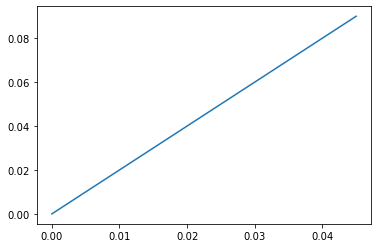

In [29]:
# Simulate the behavior of the system given a fixed input:
init_state = np.array([0., 0., 0., 0.])
input = np.array([0.5, 1.])
    
step_size = 0.5
sim = generate_casadi_func_behavior(step_size)

number_of_steps = 10
states = np.zeros((number_of_states, number_of_steps))
states[:,0] = init_state
for i in range(1,number_of_steps):
    previous_state = states[:,i-1]
    current_state = np.array(sim(previous_state, input))
    states[:, i] = np.squeeze(current_state)
    print(current_state.T)    
    
# plot it out:
plt.plot(states[0,:], states[1,:])
#plt.show()

In [30]:
def cost_state(current_state, state_reference):
    diff = current_state - state_reference
    location_error = diff[0]*diff[0] + diff[1]*diff[1]
    velocity_error = diff[2]*diff[2] + diff[3]*diff[3]
    
    return 10*location_error + velocity_error

def generate_cost_function(step_size, horizon): 
    """
    Single shot cost function.
    """
    
    # arguments get_next_state are (state, input)
    get_next_state = generate_casadi_func_behavior(step_size)
    
    initial_state = cd.SX.sym('initial_state', number_of_states, 1)
    input_all_steps = cd.SX.sym('input_all_steps', number_of_inputs*horizon, 1)
    state_reference = cd.SX.sym('state_reference', number_of_states, 1)
    
    cost=cd.SX.sym('cost',1,1)
    cost=0
    current_state=initial_state
    for i in range(1,horizon+1):
        input = input_all_steps[(i-1)*number_of_inputs:i*number_of_inputs]
        current_state = get_next_state(current_state, input)
        cost = cost + cost_state(current_state, state_reference)
    
    cost_func = cd.Function('integrator', [initial_state, input_all_steps, state_reference], [cost])
    
    return cost_func

In [31]:
# example using the cost function
horizon = 4
step_size = 1
inputs = np.zeros((8, 1)) # use just 4 steps
initial_state = np.zeros((4,1))

state_reference = np.zeros((4,1))
state_reference[0] = 10.
state_reference[1] = 7.

cost_func = generate_cost_function(step_size, horizon) 

print(np.array(cost_func(initial_state, inputs, state_reference)))

[[5960.]]


In [32]:
# solve an optimal control problem:
horizon = 20
step_size = 1

state_reference = np.zeros((4,1))
state_reference[0] = 10.
state_reference[1] = 7.

input_all_steps = cd.SX.sym('input_all_steps', number_of_inputs*horizon, 1)
initial_state = np.zeros((4,1))

cost_func = generate_cost_function(step_size, horizon)
f_ = lambda inputs: cost_func(initial_state, input_all_steps, state_reference)
g_ = lambda x: 0
# min f 
#  st. g=0
max_input = 2
# 'g': cd.fmax(cd.fabs(input_all_steps),max_input)-max_input
nlp = {'x': input_all_steps, 'f':f_(input_all_steps), 'g': input_all_steps}
S = nlpsol('S', 'ipopt', nlp)
print(S)

initial_state_solver = np.zeros(input_all_steps.shape)
#low = cd.SX.ones(initial_state_solver.shape)*max_input*-1
#high = np.ones(initial_state_solver.shape)*max_input

r = S(x0=initial_state_solver,lbg=-max_input, ubg=max_input)
optimal_inputs = r['x']
#print('x_opt: ', x_opt)
#print(S)

S:(x0[40],p[],lbx[40],ubx[40],lbg[40],ubg[40],lam_x0[40],lam_g0[40])->(x[40],f,g[40],lam_x[40],lam_g[40],lam_p[]) IpoptInterface
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       40
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   

In [33]:
cost_func(initial_state, optimal_inputs, state_reference)

DM(22032.9)

In [34]:
optimal_inputs

DM([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -2, -2])

In [35]:
get_next_state = generate_casadi_func_behavior(step_size=1)

simulated_states = np.zeros((number_of_states,horizon+1))
for i in range(0, horizon):
    print("simulating i=" + str(i))
    x = simulated_states[:,i]
    u = optimal_inputs[(i)*number_of_inputs:(i+1)*number_of_inputs]
    next_state = np.squeeze(get_next_state(x, u))
    simulated_states[:,i+1] = next_state


simulating i=0
simulating i=1
simulating i=2
simulating i=3
simulating i=4
simulating i=5
simulating i=6
simulating i=7
simulating i=8
simulating i=9
simulating i=10
simulating i=11
simulating i=12
simulating i=13
simulating i=14
simulating i=15
simulating i=16
simulating i=17
simulating i=18
simulating i=19


In [36]:
print(simulated_states.T)
print(optimal_inputs)

[[0.         0.         0.         0.        ]
 [0.         0.         0.02       0.02      ]
 [0.02       0.02       0.04       0.04      ]
 [0.06       0.06       0.06       0.06      ]
 [0.12       0.12       0.08       0.08      ]
 [0.2        0.2        0.1        0.1       ]
 [0.3        0.3        0.12       0.12      ]
 [0.42       0.42       0.14       0.14      ]
 [0.56000001 0.56000001 0.16       0.16      ]
 [0.72000001 0.72000001 0.18       0.18      ]
 [0.90000001 0.90000001 0.2        0.2       ]
 [1.10000001 1.10000001 0.22       0.22      ]
 [1.32000001 1.32000001 0.24       0.24      ]
 [1.56000002 1.56000002 0.26       0.26      ]
 [1.82000002 1.82000002 0.28       0.28      ]
 [2.10000002 2.10000002 0.3        0.3       ]
 [2.40000002 2.40000002 0.32       0.32      ]
 [2.72000003 2.72000003 0.34       0.34      ]
 [3.06000003 3.06000003 0.36       0.36      ]
 [3.42000003 3.42000003 0.38       0.38      ]
 [3.80000004 3.80000004 0.36000002 0.36000002]]
[2, 2, 2, 2,

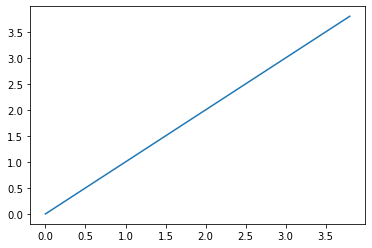

In [37]:
plt.plot(simulated_states[0,:], simulated_states[1,:])